# Processing

In [117]:
import os
import numpy as np
import librosa
import soundfile as sf
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

### Data Augmentation

In [75]:
class AudioAugmentation:
    def read_audio_file(self, file_path):
        data, sample_rate = librosa.load(file_path, sr=16000, mono=True)
        return data, sample_rate

    def write_audio_file(self, file, data, sample_rate):
        sf.write(file, data, sample_rate, subtype='PCM_16')

    def add_noise(self, data):
        noise = np.random.randn(len(data))  # Tạo nhiễu theo độ dài của dữ liệu
        data_noise = data + 0.005 * noise
        return data_noise

    def shift(self, data):
        timeshift_fac = np.random.uniform(-0.2, 0.2)  # Shift lên đến 20% chiều dài dữ liệu
        start = int(len(data) * timeshift_fac)

        if start > 0:
            shifted_data = np.pad(data, (start, 0), mode='constant')[:len(data)]
        else:
            shifted_data = np.pad(data, (0, -start), mode='constant')[-len(data):]

        return shifted_data

    def stretch(self, data, rate=1.0): # Kéo dãn tín hiệu
        return librosa.effects.time_stretch(data, rate=rate)

    def change_volume(self, data, factor=0.5):
        return data * factor

    def add_silence(self, data, silence_duration_sec=0.5, sr=16000):
        silence = np.zeros(int(silence_duration_sec * sr))
        position = np.random.randint(0, len(data))
        return np.concatenate((data[:position], silence, data[position:]))

    def random_crop(self, data, duration_sec, sr):
        start = np.random.randint(0, len(data) - duration_sec * sr)
        return data[start:start + duration_sec * sr]

    def add_background_noise(self, data, noise_level=0.1):
        background_noise = np.random.randn(len(data)) * noise_level
        return data + background_noise

    def add_echo(self, data, sr, delay=0.2, decay=0.4):
        echo_samples = int(delay * sr)  # Số mẫu của độ trễ
        echo_signal = np.pad(data, (echo_samples, 0), 'constant', constant_values=(0, 0))
        output_signal = data + decay * echo_signal[:len(data)]
        return output_signal

# Tạo một instance từ lớp AudioAugmentation
aa = AudioAugmentation()

input_dir = 'data_infant_cry/burping'
output_dir = 'data_normalized/burping'
# discomfort' 2
# tired' 2
# belly_pain' 6
# burping' 8

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

file_list = os.listdir(input_dir)

for file in file_list:
    if not file.startswith('.'):
        # Đọc file âm thanh
        data, sr = aa.read_audio_file(os.path.join(input_dir, file))

        # Thực hiện các phép augmentation
        data_noise = aa.add_noise(data)  # Thêm nhiễu
        data_shift = aa.shift(data)  # Dịch chuyển thời gian
        data_stretch = aa.stretch(data, 0.8)  # Kéo dãn thời gian
        data_volume_adjusted = aa.change_volume(data, factor=1.5)  # Thay đổi âm lượng
        data_with_silence = aa.add_silence(data, silence_duration_sec=0.5, sr=sr)  # Thêm khoảng lặng
        data_background_noise = aa.add_background_noise(data)  # Thêm âm thanh nền
        data_echo = aa.add_echo(data, sr)  # Thêm hiệu ứng tiếng vang

        # Lưu file sau khi augmentation
        aa.write_audio_file(os.path.join(output_dir, 'generated_noise' + file), data_noise, sr)
        aa.write_audio_file(os.path.join(output_dir, 'generated_shift' + file), data_shift, sr)
        aa.write_audio_file(os.path.join(output_dir, 'generated_stretch' + file), data_stretch, sr)
        aa.write_audio_file(os.path.join(output_dir, 'generated_volume_adjusted' + file), data_volume_adjusted, sr)
        aa.write_audio_file(os.path.join(output_dir, 'generated_silence' + file), data_with_silence, sr)
        aa.write_audio_file(os.path.join(output_dir, 'generated_background_noise_' + file), data_background_noise, sr)
        aa.write_audio_file(os.path.join(output_dir, 'generated_echo_' + file), data_echo, sr)

### 1. Pre-processing

In [76]:
sample_rate = 16000
frame_length = int(0.032 * sample_rate)  # 32ms
hop_length = int(0.016 * sample_rate)    # 16ms

def select_cry_frames_using_energy(signal: np.ndarray, frame_length, hop_length, thresh=0.05) -> list:
    energy = np.array([
        sum(abs(signal[i:i+frame_length]**2))
        for i in range(0, len(signal), hop_length)
    ])
    energy_norm = energy / max(energy)
    index_cry = [i for i in range(len(energy)) if energy_norm[i] >= thresh]
    return index_cry

def split_segments(index_voices: list, hop_length, sr, min_duration=0.2) -> list:
    start = index_voices[0]
    segments = []
    for i in range(1, len(index_voices)):
        if index_voices[i] - index_voices[i-1] > 1:
            segments.append((start, index_voices[i-1]))
            start = index_voices[i]
    segments.append((start, index_voices[-1]))
    return [(start, end) for start, end in segments if (end - start) * hop_length / sr >= min_duration]

### 2. Features Extraction

In [97]:
def extract_features(signal, sr, n_mfcc=13, n_fft=2048):
    # Trích xuất MFCC (Mel Frequency Cepstral Coefficients)
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
    mfccs_mean = np.mean(mfccs, axis=1)  # Trả về giá trị trung bình của MFCC qua toàn bộ tín hiệu
    
    # Trích xuất RMS (Root Mean Square)
    rms = librosa.feature.rms(y=signal, frame_length=n_fft, hop_length=hop_length)
    rms_mean = np.mean(rms)  # Trả về giá trị trung bình của RMS
    
    # Trích xuất Zero-Crossing Rate (ZCR)
    zcr = librosa.feature.zero_crossing_rate(y=signal, frame_length=n_fft, hop_length=hop_length)
    zcr_mean = np.mean(zcr)  # Trả về giá trị trung bình của Zero-Crossing Rate
    
    # Trả về tất cả các đặc trưng: MFCCs, RMS, và Zero-Crossing Rate
    return np.concatenate([mfccs_mean, [rms_mean], [zcr_mean]])

In [98]:
# Đọc tất cả các file trong thư mục
data_dir = 'data_normalized'
# Duyệt qua các lớp trong thư mục
for label in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, label)
    
    # Kiểm tra xem có phải là thư mục không
    if os.path.isdir(class_dir):
        file_count = len(os.listdir(class_dir))  # Đếm số lượng file trong thư mục của lớp
        print(f"Lớp {label} có {file_count} file.")

Lớp belly_pain có 48 file.
Lớp burping có 35 file.
Lớp discomfort có 40 file.
Lớp hungry có 50 file.
Lớp tired có 30 file.


In [99]:
X = []
y = []

# Duyệt qua từng lớp
for label in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, label)
    if not os.path.isdir(class_dir):
        continue
    for file_name in os.listdir(class_dir):
        file_path = os.path.join(class_dir, file_name)
        
        # Load file âm thanh
        signal, sr = librosa.load(file_path, sr=16000)
        
        # Chọn các frame chứa tiếng khóc dựa vào năng lượng chuẩn hóa
        index_cry = select_cry_frames_using_energy(signal, frame_length, hop_length)
        
        # Chia các frame thành các segment
        segments = split_segments(index_cry, hop_length, sr)
        
        # Trích xuất đặc trưng cho từng segment
        for (start, end) in segments:
            segment = signal[start * hop_length : end * hop_length]
            features = extract_features(signal, sr)
            X.append(features)
            y.append(label)

In [100]:
# In ra kích thước của X và y
print("Kích thước của X:", np.shape(X))
print("Kích thước của y:", np.shape(y))

Kích thước của X: (633, 15)
Kích thước của y: (633,)


### 3. Train Test Split

In [101]:
# Chuyển đổi nhãn sang dạng số
le = LabelEncoder()
y = le.fit_transform(y)

# Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [102]:
print("Kích thước của X_train:", np.shape(X_train))
print("Kích thước của X_test:", np.shape(X_test))
print("Kích thước của y_train:", np.shape(y_train))
print("Kích thước của y_test:", np.shape(y_test))

Kích thước của X_train: (443, 15)
Kích thước của X_test: (190, 15)
Kích thước của y_train: (443,)
Kích thước của y_test: (190,)


### 4. Training Model

Model: Random Forest, Accuracy: 0.978947, F1 score: 0.978708
Model: Decision Tree, Accuracy: 0.947368, F1 score: 0.946570
Model: Bagged Tree, Accuracy: 0.978947, F1 score: 0.978982
       Algorithm  Accuracy Score  F1 Score
0  Random Forest        0.978947  0.978708
1  Decision Tree        0.947368  0.946570
2    Bagged Tree        0.978947  0.978982


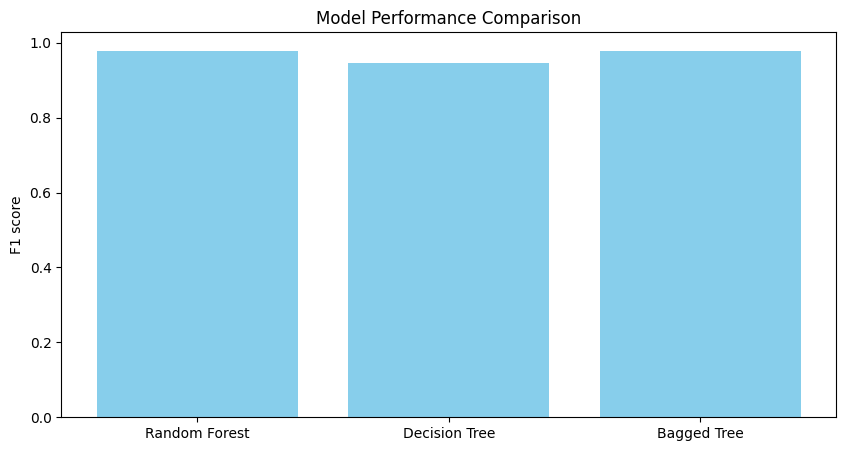

In [103]:
# Huấn luyện và đánh giá mô hình
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Decision Tree': DecisionTreeClassifier(),
    'Bagged Tree': BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100)
}

results = []
# Huấn luyện và đánh giá các mô hình
for model_name, model in models.items():
    # Perform cross-validation
    scores = cross_val_score(model, X, y, cv=5, scoring='f1_weighted')
    # Train the model on the training data
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)  
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    # Calculate F1 score (weighted)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Model: {model_name}, Accuracy: {accuracy:.6f}, F1 score: {f1:.6f}")
    results.append({'Algorithm': model_name, 'Accuracy Score': accuracy, 'F1 Score': f1})

# Chuyển kết quả sang DataFrame
results_df = pd.DataFrame(results)

# Hiển thị bảng kết quả
print(results_df)

# Vẽ biểu đồ độ chính xác
plt.figure(figsize=(10, 5))
plt.bar(results_df['Algorithm'], results_df['F1 Score'], color='skyblue')
plt.title('Model Performance Comparison')
plt.ylabel('F1 score')
plt.show()

#### Confusion matrix

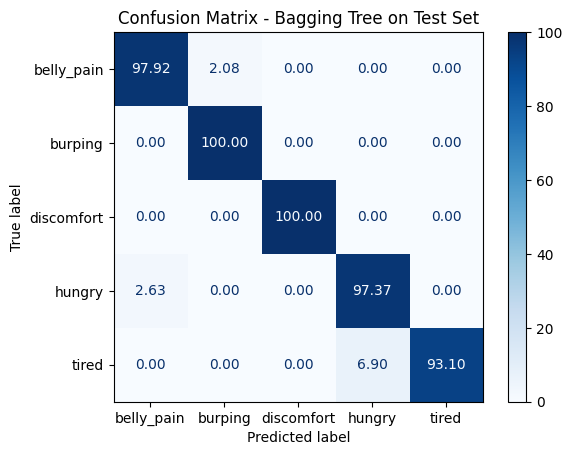

In [118]:
# Huấn luyện mô hình Random Forest
bg_model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100)
bg_model.fit(X_train, y_train)

# Dự đoán và tính ma trận nhầm lẫn
y_pred = bg_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=['belly_pain', 'burping', 'discomfort', 'hungry', 'tired'])
disp.plot(cmap='Blues', values_format=".2f")  
plt.title("Confusion Matrix - Bagging Tree on Test Set")
plt.show()

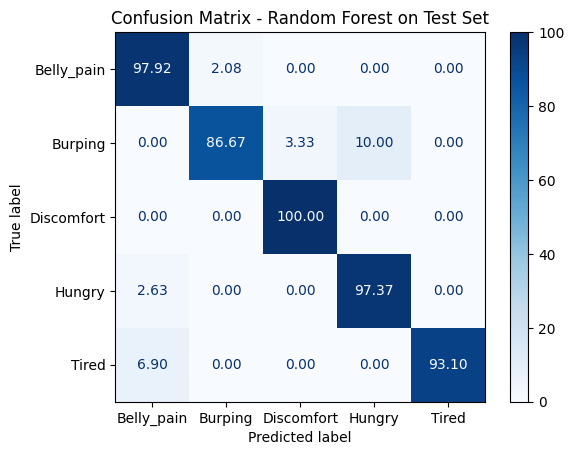

In [104]:
# Huấn luyện mô hình Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Dự đoán và tính ma trận nhầm lẫn
y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=['Belly_pain', 'Burping', 'Discomfort', 'Hungry', 'Tired'])
disp.plot(cmap='Blues', values_format=".2f")  
plt.title("Confusion Matrix - Random Forest on Test Set")
plt.show()

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV

# param_grid = {'n_estimators': [50, 100, 200, 300, 400],
#               'max_depth': [None, 10, 20, 30, 40, 50],
#               'max_features': ['sqrt', 'log2'],
#               'min_samples_split': [2, 5, 10],
#               'min_samples_leaf': [1, 2, 4],
#               'bootstrap': [True, False],
#               'criterion': ['gini', 'entropy']
#              }
# grid_search = RandomizedSearchCV (RandomForestClassifier(), param_grid, n_iter=100, cv=5, scoring='f1_weighted')
# grid_search.fit(X_train, y_train)
# print("Best parameters: ", grid_search.best_params_)

In [ ]:
# # Khởi tạo mô hình với các siêu tham số tốt nhất
# best_params = {'n_estimators': 50,
#                'min_samples_split': 2,
#                'min_samples_leaf': 1,
#                'max_features': 'sqrt',
#                'max_depth': 50,
#                'criterion': 'entropy',
#                'bootstrap': True}

# model = RandomForestClassifier(**best_params)

# # Huấn luyện mô hình
# model.fit(X_train, y_train)

# # Dự đoán trên tập kiểm tra
# y_pred = model.predict(X_test)

# # Đánh giá mô hình
# accuracy = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred, average='weighted')

# print(f"Accuracy: {accuracy} F1 Score: {f1}")